<a href="https://colab.research.google.com/github/Vertex138/DS-Unit-2-Kaggle-Challenge/blob/master/submissions/Assignment221.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [0]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

     |████████████████████████████████| 102kB 2.7MB/s 


In [0]:
# Imports:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz

from google.colab import files

In [0]:
df = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
dfTest = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
dfSample = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

df.shape, dfTest.shape

((59400, 41), (14358, 40))

In [0]:
# Split 'df' into Test and Validate groups
dfTrain, dfVal = train_test_split(df, random_state=138)

In [0]:
# Check the non-numeric data to see what should be trimmed and refined
df.select_dtypes(include='number').describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [0]:
# Check the non-numeric data to see what should be trimmed and refined
df.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq
recorded_by,59400,1,GeoData Consultants Ltd,59400
public_meeting,56066,2,True,51011
permit,56344,2,True,38852
status_group,59400,3,functional,32259
source_class,59400,3,groundwater,45794
quantity_group,59400,5,enough,33186
quantity,59400,5,enough,33186
management_group,59400,5,user-group,52490
quality_group,59400,6,good,50818
waterpoint_type_group,59400,6,communal standpipe,34625


In [0]:
# Wrangle inputted datasets
def wrangle(_):
  df = _.copy()
    
  df['latitude'] = df['latitude'].replace(-2e-08, 0)
  zeroColumns = ['longitude', 'latitude', 'population', 'construction_year']
  for _ in zeroColumns:
    df[_] = df[_].replace(0, np.nan)
  
  dropColumns = ['quantity_group', 'region_code', 'recorded_by']
  df = df.drop(columns=dropColumns)
  return df

In [0]:
# Wrangle the datasets
dfTrain = wrangle(dfTrain)
dfTest = wrangle(dfTest)
dfVal = wrangle(dfVal)

In [0]:
# Group features and pick the good ones, and pick a target
target = 'status_group'

preFeatures = dfTrain.drop(columns=[target, 'id'])
numFeatures = preFeatures.select_dtypes(include='number').columns.tolist()
carFeatures = preFeatures.select_dtypes(exclude='number').nunique()
catFeatures = carFeatures[carFeatures <= 128].index.tolist()

features = numFeatures + catFeatures

xTrain = dfTrain[features]
yTrain = dfTrain[target]
xVal = dfVal[features]
yVal = dfVal[target]
xTest = dfTest[features]

In [0]:
# Pipeline to be used for trees
treePipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(random_state=138)
)

In [0]:
# Get baseline accuracy
treePipeline.fit(xTrain, yTrain)
print('Train Accuracy', treePipeline.score(xTrain, yTrain))
print('Validation Accuracy', treePipeline.score(xVal, yVal))

Train Accuracy 0.9953984287317621
Validation Accuracy 0.7552861952861953


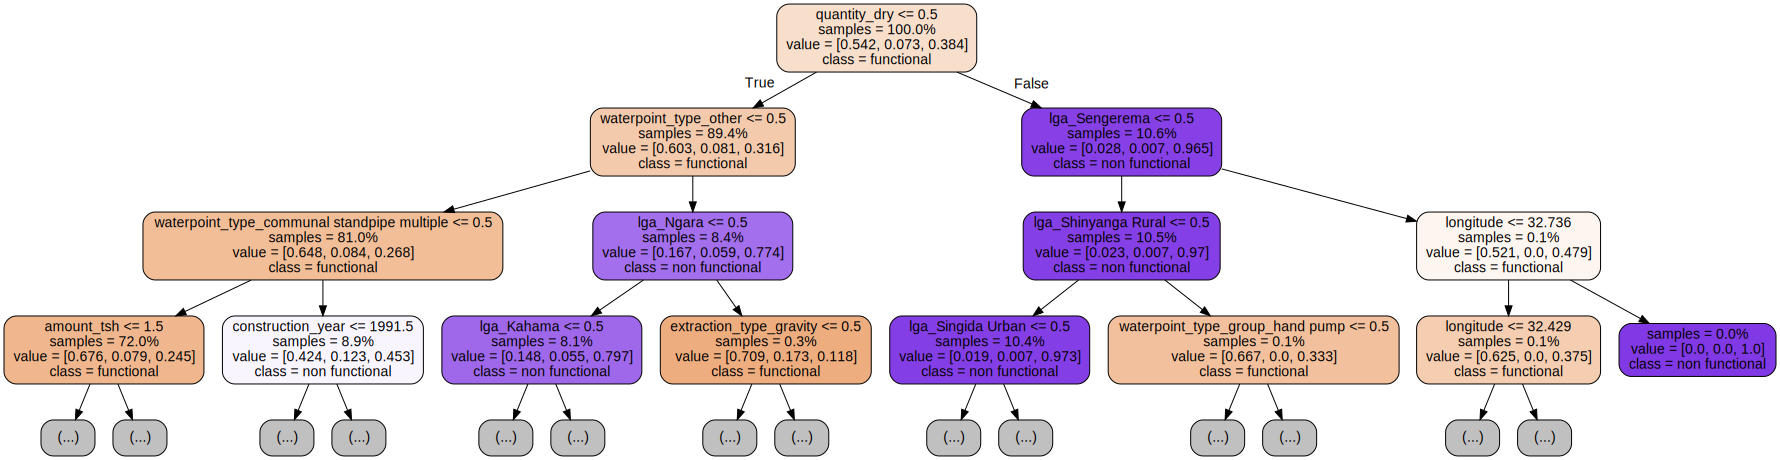

In [0]:
# Plot basic tree
model = treePipeline.named_steps['decisiontreeclassifier']
encoder = treePipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(xVal).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

In [0]:
# AFTER USING THE CODE FROM THE CELL BELOW:
# The best accurate tree based on 
# 6 24 77.865
# 10 26 77.558

In [0]:
# A loop to determine the most accurate trees
maxVarAcc = 0;
for _x in range(10,51):
  for _y in range(1,51):
    score = 0
    for _s in range(1,6):
      loopPipeline = make_pipeline(
          ce.OneHotEncoder(use_cat_names=True), 
          SimpleImputer(strategy='mean'), 
          DecisionTreeClassifier(min_samples_leaf = _x, max_depth = _y, random_state=_s))
      loopPipeline.fit(xTrain, yTrain)
      score += loopPipeline.score(xVal, yVal)
    score /= 5
    print("leaf",_x,"\tdepth",_y,"\tVarAcc%",score)
    if (score > maxVarAcc):
      maxVarAcc = score
      print("^^^ New Best Var Acc")

leaf 10 	depth 1 	VarAcc% 0.6451178451178451
^^^ New Best Var Acc
leaf 10 	depth 2 	VarAcc% 0.695016835016835
^^^ New Best Var Acc
leaf 10 	depth 3 	VarAcc% 0.6983164983164983
^^^ New Best Var Acc
leaf 10 	depth 4 	VarAcc% 0.7095622895622896
^^^ New Best Var Acc
leaf 10 	depth 5 	VarAcc% 0.7121212121212122
^^^ New Best Var Acc
leaf 10 	depth 6 	VarAcc% 0.7173737373737373
^^^ New Best Var Acc
leaf 10 	depth 7 	VarAcc% 0.7239057239057239
^^^ New Best Var Acc
leaf 10 	depth 8 	VarAcc% 0.7324579124579125
^^^ New Best Var Acc
leaf 10 	depth 9 	VarAcc% 0.7398653198653199
^^^ New Best Var Acc
leaf 10 	depth 10 	VarAcc% 0.7447811447811448
^^^ New Best Var Acc
leaf 10 	depth 11 	VarAcc% 0.7456565656565657
^^^ New Best Var Acc
leaf 10 	depth 12 	VarAcc% 0.7532659932659933
^^^ New Best Var Acc
leaf 10 	depth 13 	VarAcc% 0.7609158249158249
^^^ New Best Var Acc
leaf 10 	depth 14 	VarAcc% 0.7627205387205387
^^^ New Best Var Acc
leaf 10 	depth 15 	VarAcc% 0.7661548821548823
^^^ New Best Var Acc
leaf 

KeyboardInterrupt: ignored

In [0]:
bestPipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(min_samples_leaf = 10, max_depth = 26, random_state=138))
bestPipeline.fit(xTrain, yTrain)
bestPipeline.score(xVal, yVal)

0.7758249158249159

In [0]:
testPred = bestPipeline.predict(xTest)
dfSubmit = pd.DataFrame(columns=['id', 'status_group'])
dfSubmit.id = dfTest.id.copy()
dfSubmit.status_group = testPred
dfSubmit.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
dfSubmit.to_csv('waterpumpsKaggle4.csv', index=False)
files.download('waterpumpsKaggle4.csv')